In [1]:
import numpy as np
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
plt.rcParams['mathtext.fontset'] = 'stix'

In [2]:
device = torch.device("cpu")

### Define network

In [3]:
class STM(nn.Module):
    def __init__(self, D_in, H, D_out):
        """
        Initialize the attributes of STM.
        """
        super(STM, self).__init__() # inherit the __init__ from nn.Module.
        
        self.input=torch.rand(D_in)            
        self.linear1=nn.Linear(D_in, H)
        self.linear2=nn.Linear(H, D_out)
        self.x = self.init_x()            # initialize self.x with method init_x().
        
    def init_x(self):
        """
        Initialize self.x with two neurons.
        """
        return nn.Parameter(self.input)
        
    def forward(self):
        """
        Forward propagation.
        """
        h_relu = self.linear1(self.x).clamp(min=0)
        y_pred = self.linear2(h_relu)
        
        return y_pred

### Predefined parameters

In [4]:
# Average energy
E_mean=10
# D_in=Input dimensions, H=Hidden dimension, D_out=Number of classes
D_in, H, D_out = 50, 100, 64
# Learning rate
lr=0.001
# Number of auglag
num_auglag=10
# Number of optimization
num_ops=1500


### Predefined data

In [5]:
# Lagrange multiplier
l = 0.0
# Penalty factor
mu = 1.0
# Penalty update factor
sigma = 1.5
# Penalty safeguard
mu_max=10
# Convergence tolerance
ec = 1e-7
# Tolerance factor of constraint
tolerance=0.01

# Artifical energy levels
E=np.array([(i+1)**2 for i in range(D_out)])
E=torch.tensor(E, requires_grad=False, dtype=torch.float32)

# Target distribution
y=torch.ones(D_out)/D_out

### Predefined functions

In [6]:
softmax=torch.nn.Softmax(dim=-1)

### Building model

In [7]:
model = STM(D_in, H, D_out)

loss_fn = torch.nn.MSELoss(reduction='sum')
# optimizer = torch.optim.SGD(model1.parameters(), lr=lr)

### Plot probability distribution before training

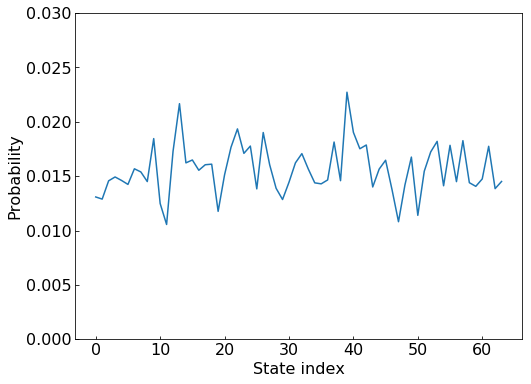

In [8]:
# Data
init_dist = softmax(model()).detach().numpy()

# Plot
fig, ax = plt.subplots(figsize=(8,6))
ax.plot(init_dist)
ax.set_xlabel('State index', size=16)
ax.set_ylabel('Probability', size=16)
ax.set_ylim(0.0,0.03)
ax.tick_params(axis='both', which='major', direction='in', labelsize=16)
plt.show()

### Average energy before training

In [9]:
print(torch.mean(E*softmax(model())))

tensor(21.8366, grad_fn=<MeanBackward0>)


### Training

In [10]:
# Initial constraint
C_best=(torch.mean(E*softmax(model()))-E_mean).detach_().numpy()
aC_best=np.abs(C_best)

for j in range(num_auglag):
    
    if j!=0: print(j, loss.item())
    for i in range(num_ops):
    
        Y=model()
        loss = loss_fn(y,softmax(Y)) + 0.5*mu*(torch.mean(E*softmax(Y))-E_mean)**2\
               + l*(torch.mean(E*softmax(Y))-E_mean)
    
        model.zero_grad()
        loss.backward()
    
        with torch.no_grad():
            for param in model.parameters():
                param -= lr * param.grad
    
    C_p=(torch.mean(E*softmax(Y))-E_mean).detach_().numpy()
    aC_p=np.abs(C_p)
    if aC_p <= tolerance*aC_best:
        if aC_p <= ec: break
        # Update Lagrange multiplier.
        l += mu*C_p
        aC_best=aC_p
    else:
        # This is to make sure mu_{k+1}=sigma*mu_k but mu always less than or equal to mu_max.
        mu=min(sigma*mu, mu_max)


1 0.012524750083684921
2 0.010905001312494278
3 0.010043791495263577
4 0.009490476921200752
5 0.009096739813685417
6 0.008797812275588512
7 0.008560453541576862
8 0.008365669287741184
9 0.008201736956834793


### Plot probability distribution after training

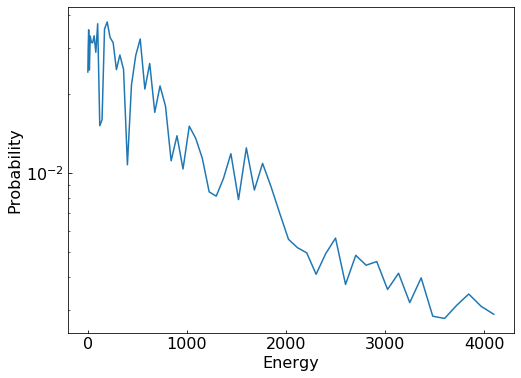

In [11]:
# Data
final_dist = softmax(model()).detach().numpy()

# Plot
fig, ax=plt.subplots(figsize=(8,6))
ax.plot(E.detach().numpy(), final_dist)
ax.set_xlabel('Energy', size=16)
ax.set_ylabel('Probability', size=16)
ax.set_yscale('log')
ax.tick_params(axis='both', which='both', direction='in', labelsize=16)
plt.show()

### Fitting with exponential

In [12]:
from scipy.optimize import curve_fit

def func(x, a, b):
    return a * np.exp(-b * x)

xdata=E.detach().numpy()[2:]
ydata=final_dist[2:]

popt, pcov = curve_fit(func, xdata, ydata)

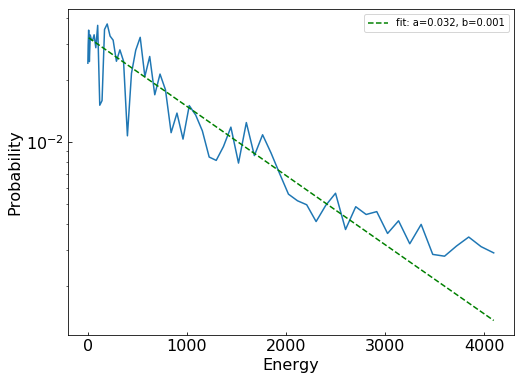

In [13]:
# Data
final_dist = softmax(model()).detach().numpy()

# Plot
fig, ax=plt.subplots(figsize=(8,6))
ax.plot(E.detach().numpy(),final_dist)
ax.plot(xdata, func(xdata, *popt), 'g--', label='fit: a=%5.3f, b=%5.3f' % tuple(popt))
ax.set_xlabel('Energy', size=16)
ax.set_ylabel('Probability', size=16)
ax.set_yscale('log')
ax.tick_params(axis='both', which='major', direction='in', labelsize=16)
ax.legend()
plt.show()

### Fit with linear 

In [14]:
from scipy.optimize import curve_fit

def func(x, m, b):
    return m * x + b

xdata=E.detach().numpy()
ydata=np.log(final_dist)

popt, pcov = curve_fit(func, xdata, ydata)

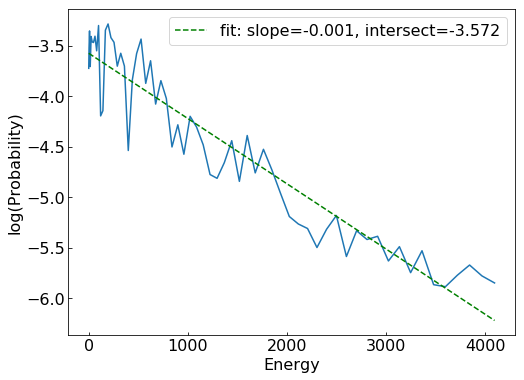

In [15]:
# Data
final_dist = softmax(model()).detach().numpy()

# Plot`
fig, ax=plt.subplots(figsize=(8,6))
ax.plot(E.detach().numpy(), np.log(final_dist))
ax.plot(xdata, func(xdata, *popt), 'g--', label='fit: slope=%5.3f, intersect=%5.3f' % tuple(popt))
ax.set_xlabel('Energy', size=16)
ax.set_ylabel('log(Probability)', size=16)
ax.tick_params(axis='both', which='major', direction='in', labelsize=16)
ax.legend(fontsize=16)
plt.show()

### Average energy after training

In [16]:
torch.mean(E*softmax(model()))

tensor(9.9998, grad_fn=<MeanBackward0>)

### Constraint term after traiing

In [17]:
torch.mean(E*softmax(model()))-E_mean

tensor(-0.0002, grad_fn=<SubBackward0>)

In [18]:
l

0.0035333633422851562